## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pprint import pprint

import pandas as pd

from storesales.baseline.sales_predictor import SalesPredictor
from storesales.light_gbm.lgb_tuner.family_lgb_params import FamilyLightGBMModelParams
from storesales.light_gbm.lgb_tuner.lgb_model_tuner import LightGBMModelTuner
from storesales.light_gbm.param_dataclasses import ExtractFeaturesParam

from storesales.light_gbm.fit_evaluate.evaluate_models import evaluate
from storesales.light_gbm.feature_engineering.ts_fresh_features import (
    make_roll,
    make_roll_features,
    get_minimal_fc_parameters,
)
from storesales.light_gbm.dataset import make_family_datasets
from storesales.light_gbm.preprocessing import preprocess
from storesales.light_gbm.utils import (
    save_submission,
    make_submission_predictions,
    make_submission_forecast_plot,
    load_oil,
    load_stores,
    create_date_features,
    combine_baseline_losses,
)
from storesales.constants import (
    TEST_DATE_RANGE,
    EXTERNAL_TRAIN_PATH,
    EXTERNAL_TEST_PATH,
    EXTERNAL_OIL_PATH,
    EXTERNAL_STORES_PATH,
)

## Load && Preprocess Data

In [3]:
train_df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])
test_df = pd.read_csv(EXTERNAL_TEST_PATH, parse_dates=["date"])

In [4]:
stores_df = load_stores(EXTERNAL_STORES_PATH)
oil_df = load_oil(EXTERNAL_OIL_PATH)

In [5]:
preprocessed_df = preprocess(train_df)

## Baseline Model
Some store-family pairs do not have enough data to get lags. I will use baseline model for these pairs.

### Prepare Data

In [6]:
baseline_train_df = train_df.copy()
baseline_test_df = test_df.copy()

baseline_train_df.rename(columns={"date": "ds", "sales": "y"}, inplace=True)
baseline_test_df.rename(columns={"date": "ds"}, inplace=True)

### Load Model && Fit && Predict

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns


class AdvancedPredictor:
    """Class to combine and compare baseline models and LightGBM."""

    def __init__(self):
        self.models = {}
        self.losses = {}
        self.predictions = {}
        self.combined_loss = None
        self.combined_prediction = None

    def make_family_loss_plot(self, family: str):
        mean_loss = self.combined_loss.mean(axis=1).rename("loss").reset_index()
        family_store_mean_loss = mean_loss.reset_index()
        family_store_mean_loss = family_store_mean_loss[
            family_store_mean_loss["family"] == family
        ]

        family_loss_pivot = family_store_mean_loss.pivot(
            index="store_nbr", columns="model", values="loss"
        )

        palette = sns.color_palette(
            "dark:#5A9_r", n_colors=len(family_loss_pivot.columns)
        )
        family_loss_pivot.plot(kind="bar", width=0.7, figsize=(20, 10), color=palette)
        plt.title(f"Mean Loss by Model for Each Store in Family {family}", fontsize=18)
        plt.xlabel("Store Number", fontsize=16)
        plt.ylabel("Mean Loss", fontsize=16)
        plt.legend(title="Model", fontsize=16, title_fontsize=16)
        plt.xticks(rotation=90)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.figure()
        plt.tight_layout()
        plt.show()    

    def make_overall_family_loss_plot(self):
        mean_loss = self.combined_loss.mean(axis=1).rename("loss").reset_index()
        family_mean_loss = (
            mean_loss.groupby(["family", "model"])["loss"].mean().reset_index()
        )

        family_loss_pivot = family_mean_loss.pivot(
            index="family", columns="model", values="loss"
        )

        palette = sns.color_palette(
            "dark:#5A9_r", n_colors=len(family_loss_pivot.columns)
        )

        family_loss_pivot.plot(kind="bar", width=0.7, color=palette, figsize=(20, 10))
        plt.title("Mean Loss by Model for Each Family", fontsize=18)
        plt.xlabel("Family", fontsize=16)
        plt.ylabel("Mean Loss", fontsize=16)
        plt.legend(title="Model", fontsize=16, title_fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        plt.show()

    def get_optimal_prediction(self):
        family_store_mean_loss = self.combined_loss.mean(axis=1).rename("loss")
        min_loss_ids = family_store_mean_loss.groupby(["family", "store_nbr"]).idxmin()
        return self.combined_prediction.loc[min_loss_ids].copy()

    def load_sales_predictors(self, model_names: list[str], file_names: list[str]):
        for model_name, file_name in zip(model_names, file_names):
            self.models[model_name] = SalesPredictor.load(file_name)

    def load_losses(self):
        for model_name, model in self.models.items():
            loss_file_path = model.eval_loss_csv
            loss_df = pd.read_csv(loss_file_path, index_col=["family", "store_nbr"])
            self.losses[model_name] = loss_df

        self.combined_loss = pd.concat(self.losses)
        self.combined_loss.index.names = ["model", "family", "store_nbr"]

    def fit_models(self, df: pd.DataFrame):
        for model_name, model in self.models.items():
            print(f"Fitting {model_name}...")
            model.fit(df)

    def predict_models(self, df: pd.DataFrame):
        for model_name, model in self.models.items():
            print(f"Predicting with {model_name}...")
            self.predictions[model_name] = model.predict(df)
            self.predictions[model_name].rename(columns={"yhat": "sales"}, inplace=True)
        
        self.combined_prediction = pd.concat(self.predictions)
        self.combined_prediction.index.names = ["model", "index"]
        self.combined_prediction.reset_index(inplace=True)
        self.combined_prediction.set_index(["model", "family", "store_nbr"], inplace=True)
    
    def add_lightgbm_loss(self, loss_df: pd.DataFrame, model_name: str):
        self.losses[model_name] = loss_df
        
        self.combined_loss = pd.concat(self.losses)
        self.combined_loss.index.names = ["model", "family", "store_nbr"]
    
    def add_lightgbm_prediction(self, prediction_df: pd.DataFrame, model_name: str):
        self.predictions[model_name] = prediction_df
        self.combined_prediction = pd.concat(self.predictions)
        self.combined_prediction.index.names = ["model", "index"]
        self.combined_prediction.reset_index(inplace=True)
        self.combined_prediction.set_index(["model", "family", "store_nbr"], inplace=True)

In [226]:
model_file_paths = [
    "daily_predictor.pkl",
    "day_of_week_predictor.pkl",
    "weighted_day_predictor.pkl",
]
model_names = ["daily", "day_of_week", "weighted_day"]
# model_names = ["daily", "day_of_week"]

In [227]:
baseline = AdvancedPredictor()

baseline.load_sales_predictors(model_names, model_file_paths)
baseline.load_losses()
baseline.fit_models(baseline_train_df)
baseline.predict_models(baseline_test_df)

Fitting daily...


100%|██████████| 1782/1782 [00:00<00:00, 1961.12it/s]


Fitting day_of_week...


100%|██████████| 1782/1782 [00:03<00:00, 582.52it/s]


Fitting weighted_day...


100%|██████████| 1782/1782 [00:01<00:00, 921.24it/s] 


Predicting with daily...


100%|██████████| 1782/1782 [00:00<00:00, 4237.46it/s]


Predicting with day_of_week...


100%|██████████| 1782/1782 [00:00<00:00, 2157.12it/s]


Predicting with weighted_day...


100%|██████████| 1782/1782 [00:44<00:00, 39.76it/s]


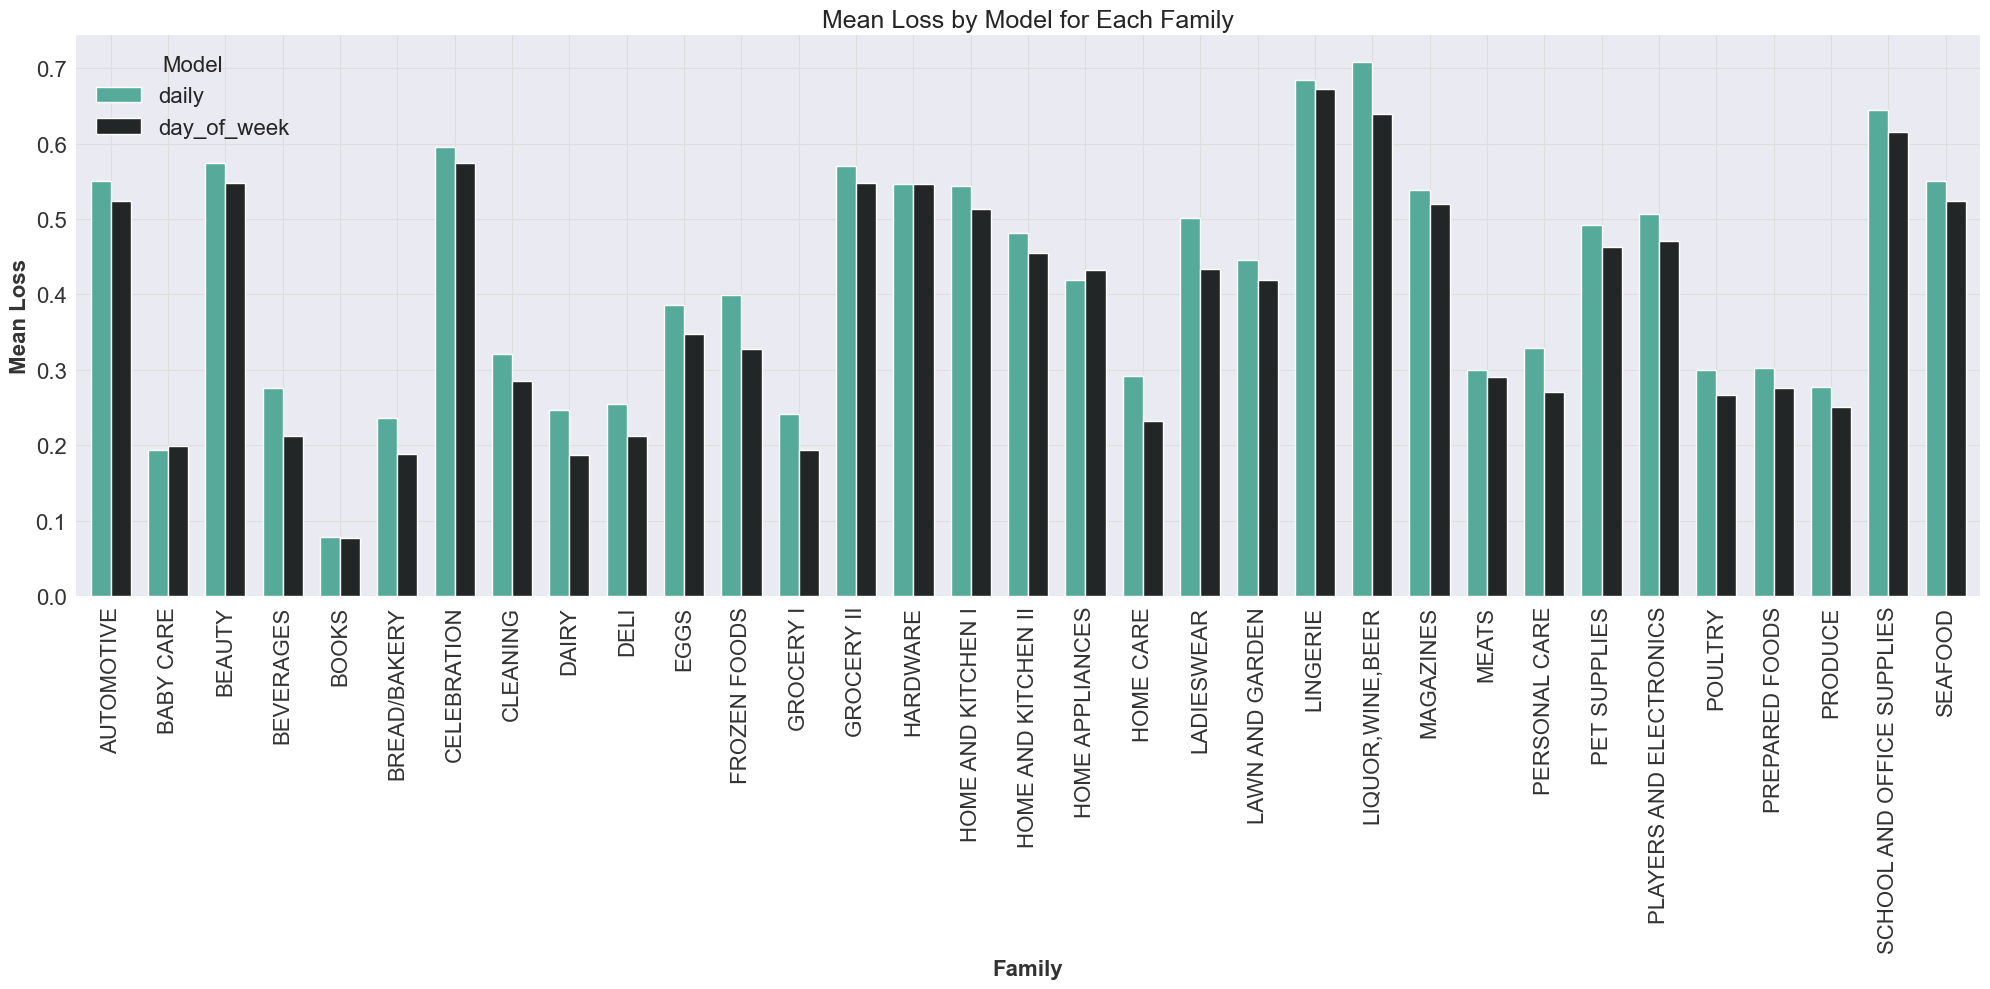

In [168]:
# baseline.make_overall_family_loss_plot()

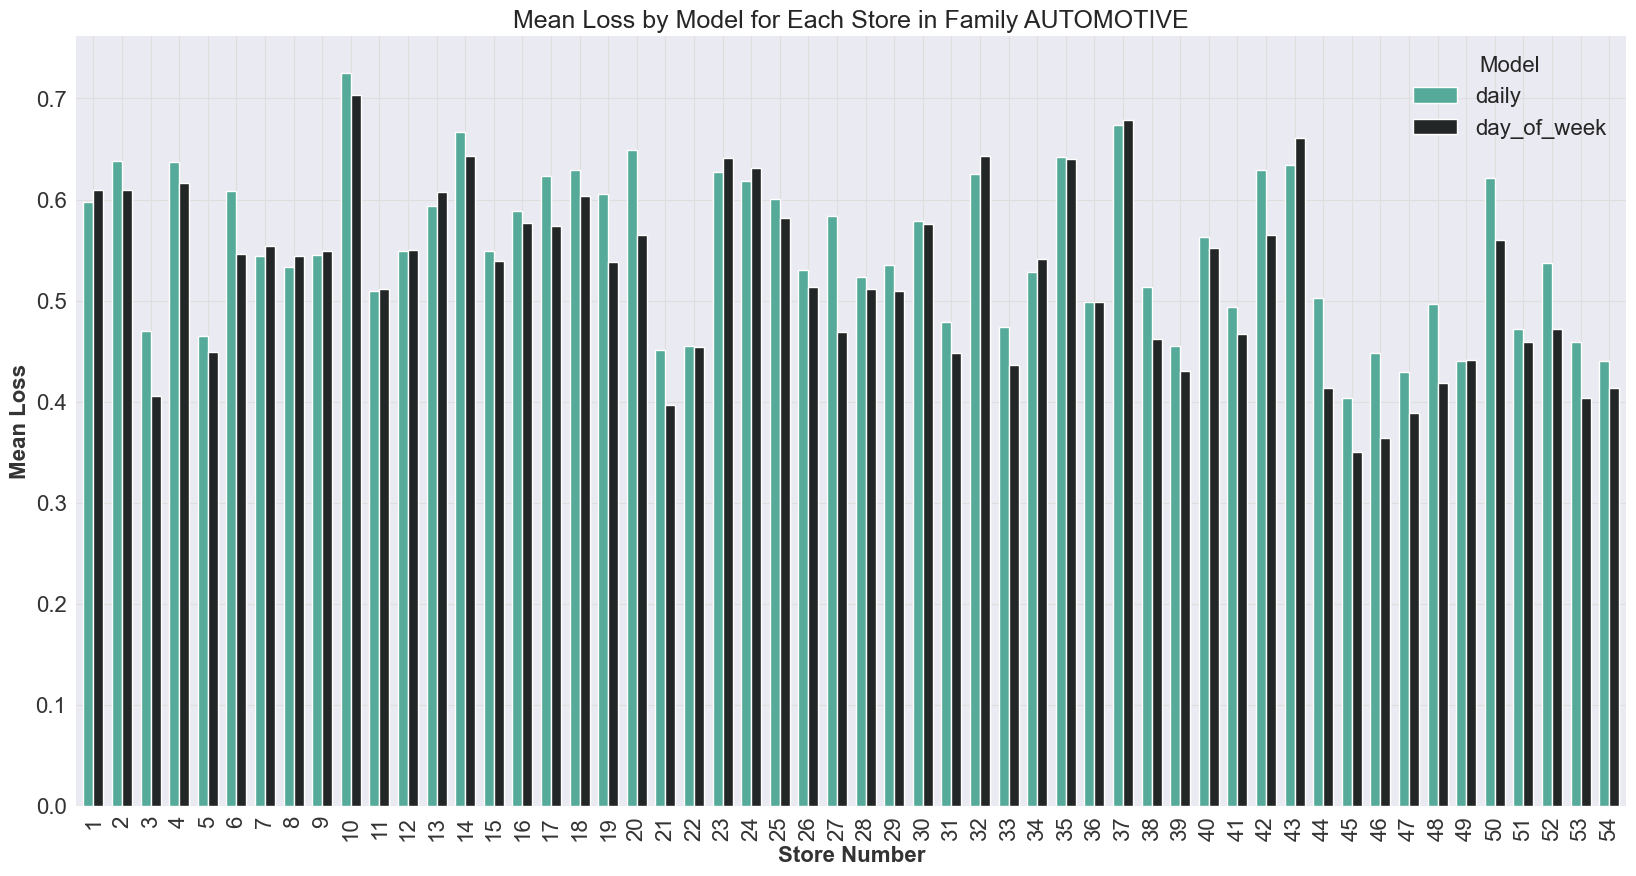

<Figure size 640x480 with 0 Axes>

In [200]:
baseline.make_family_loss_plot(family="AUTOMOTIVE")

## Darts LightGBM Implementation
### Make Family Datasets

#### Prepare Data Before Making Rolling Features
1. concatenate `preprocessed_df` and `test_df` in `data_df` to get past and future values in one df;
2. fill test period sales with 0;
3. select specific `families` for LightGBM models;
4. merge `oil_df` and `stores_df` to `data_df`;
5. filter data with `threshold_timestamp` to get enough data to train LightGBM models.



In [97]:
threshold_timestamp = pd.Timestamp("2017-04-01")
families = ["EGGS", "DAIRY", "LIQUOR,WINE,BEER"]
families = ["LIQUOR,WINE,BEER"]

In [98]:
train_test_df = pd.concat([preprocessed_df, test_df], ignore_index=True)  # 1.

train_test_df.fillna(0, inplace=True)  # 2.

data_df = train_test_df[train_test_df["family"].isin(families)].copy()  # 3.

data_df = data_df.merge(oil_df, left_on="date", right_index=True, how="left")  # 4.
data_df = data_df.merge(stores_df, on="store_nbr", how="left")

min_group_date = data_df.groupby(["family", "store_nbr"])["date"].transform("min")
filtered_data_df = data_df[min_group_date <= threshold_timestamp]  # 5.

#### Rolling Features
I'll make two types of roll features: with short and long windows.   
Combined DataFrame will have features with `short` and `long` suffixes.

##### Make Rolls
* use rolls threshold timestamp to speed up feature creation and model training;
* `sales`, `onpromotion`, `dcoilwtico` are the features to roll.

In [99]:
rolls_threshold_timestamp = pd.Timestamp("2014-02-01")
# rolls_threshold_date = pd.Timestamp("2017-03-01")

rolls_data_con = filtered_data_df["date"] >= rolls_threshold_timestamp

rolls_data_df = filtered_data_df[rolls_data_con].copy()

In [100]:
features_to_roll = ["sales", "onpromotion", "dcoilwtico"]

train_rolls_short = make_roll(rolls_data_df.copy(), features_to_roll, timeshift=9)
train_rolls_long = make_roll(rolls_data_df.copy(), features_to_roll, timeshift=28)

Rolling: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


##### Make Features
Make short and long roll features, combine them in `train_featured_df`.

In [101]:
extract_features_short_param = ExtractFeaturesParam(
    timeseries_container=train_rolls_short,
    default_fc_parameters=get_minimal_fc_parameters(),
    column_sort="date",
)
extract_features_long_param = ExtractFeaturesParam(
    timeseries_container=train_rolls_long,
    default_fc_parameters=get_minimal_fc_parameters(),
    column_sort="date",
)

In [102]:
train_featured_short = make_roll_features(extract_features_short_param, "short")
train_featured_long = make_roll_features(extract_features_long_param, "long")

Feature Extraction: 100%|██████████| 30/30 [00:59<00:00,  1.97s/it]


In [103]:
train_featured_df = pd.merge(
    train_featured_short,
    train_featured_long,
    on=["date", "store_nbr", "family"],
    how="inner",
)

#### Create Date Features
Add date features to `train_featured_df`.

In [104]:
date_features_df = create_date_features(train_featured_df, pref="date_feature_")
date_feature_cols = date_features_df.columns.to_list()

train_featured_df[date_feature_cols] = date_features_df

In [105]:
train_featured_df.head()

,date,short_sales__sum_values,short_sales__median,short_sales__mean,short_sales__standard_deviation,short_sales__variance,short_sales__root_mean_square,short_sales__maximum,short_sales__minimum,short_onpromotion__sum_values,...,long_dcoilwtico__standard_deviation,long_dcoilwtico__variance,long_dcoilwtico__root_mean_square,long_dcoilwtico__maximum,long_dcoilwtico__minimum,date_feature_day,date_feature_month,date_feature_year,date_feature_day_of_week,date_feature_day_of_year
0,2014-03-01,820.0,80.0,82.0,63.307188,4007.80,103.594401,185.0,0.0,0.0,...,2.087675,4.358389,100.692679,103.46,96.44,1,3,2014,5,60
1,2014-03-02,687.0,70.5,68.7,62.429240,3897.41,92.828336,185.0,0.0,0.0,...,2.038867,4.156977,100.875434,103.46,96.44,2,3,2014,6,61
2,2014-03-03,716.0,70.5,71.6,59.788293,3574.64,93.280223,185.0,0.0,0.0,...,2.098067,4.401885,101.145211,105.34,96.44,3,3,2014,0,62
3,2014-03-04,716.0,70.5,71.6,59.788293,3574.64,93.280223,185.0,0.0,0.0,...,1.949937,3.802256,101.390476,105.34,97.24,4,3,2014,1,63
4,2014-03-05,780.0,70.5,78.0,55.016361,3026.80,95.450511,185.0,0.0,0.0,...,1.787273,3.194344,101.542972,105.34,97.40,5,3,2014,2,64


#### Specify Lags

In [106]:
sales_cols = [col for col in train_featured_df.columns if "sales" in col]
onpromotion_cols = [col for col in train_featured_df.columns if "onpromotion" in col]
oil_cols = [col for col in train_featured_df.columns if "dcoilwtico" in col]

# onpromotion and oil features are future covariates
future_short_cols = [col for col in onpromotion_cols + oil_cols if "short" in col]
future_long_cols = [col for col in onpromotion_cols + oil_cols if "long" in col]

# sales features are past covariates
past_short_cols = [col for col in sales_cols if "short" in col]
past_long_cols = [col for col in sales_cols if "long" in col]

static_cols = ["city", "state", "type", "cluster"]

In [107]:
prev_season_short_lags = [-31, -39, -47]
prev_season_long_lags = [-29, -46]

lags_past_short_covariates = [-16, -21] + prev_season_short_lags
lags_past_long_covariates = [-16] + prev_season_long_lags

lags_future_short_covariates = [0, -7, -14] + prev_season_short_lags
lags_future_long_covariates = [0, -9] + prev_season_long_lags

lags_date_feature_covariates = [0, -16, -30, -46]

In [108]:
# future covariates lags
date_lags = {col: lags_date_feature_covariates for col in date_feature_cols}
future_short_lags = {col: lags_future_short_covariates for col in future_short_cols}
future_long_lags = {col: lags_future_long_covariates for col in future_long_cols}

# past covariates lags
past_short_lags = {col: lags_past_short_covariates for col in past_short_cols}
past_long_lags = {col: lags_past_long_covariates for col in past_long_cols}

In [109]:
lags_future_covariates = {**future_short_lags, **future_long_lags, **date_lags}
lags_past_covariates = {**past_short_lags, **past_long_lags}

#### Make Family Datasets

In [111]:
start_target_series_timestamp = rolls_threshold_timestamp - pd.Timedelta(days=40)

start_series_con = filtered_data_df["date"] > start_target_series_timestamp
# end_series_con = filtered_data_df["date"] < START_SUBMISSION_DATE

series_data = filtered_data_df[start_series_con].copy()

In [112]:
family_datasets = make_family_datasets(
    df=series_data,
    featured_df=train_featured_df,
    static_cols=static_cols,
    future_cols=list(lags_future_covariates.keys()),
    past_cols=list(lags_past_covariates.keys()),
)

In [113]:
family_datasets["EGGS"].series[0].components

KeyError: 'EGGS'

### Tune && Eval LightGBM Models
#### Tune Models

In [114]:
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [115]:
cat_static_covs = ["city", "state", "type", "cluster", "store_nbr"]
# cat_future_covs = date_feature_cols
cat_future_covs = []

param_suggestor = FamilyLightGBMModelParams(
    lags_future_covariates=lags_future_covariates,
    lags_past_covariates=lags_past_covariates,
    categorical_static_covariates=cat_static_covs,
    categorical_future_covariates=cat_future_covs,
)

In [116]:
tuner = LightGBMModelTuner(
    dataset=family_datasets, families=families, param_suggestor=param_suggestor
)

In [235]:
tuner.run_parallel_tune(n_jobs=1, eval_stride=5, n_trials=5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [118]:
best_lgb_models = tuner.fit_best(n_jobs=1)

#### Evaluate Models

In [186]:
eval_family_losses = evaluate(
    dataset=family_datasets,
    evaluate_range=TEST_DATE_RANGE,
    models=best_lgb_models,
    stride=1,
    parallel=True,
)

#### Compare with Baseline

In [228]:
baseline.add_lightgbm_loss(eval_family_losses.copy(), "LightGBM")

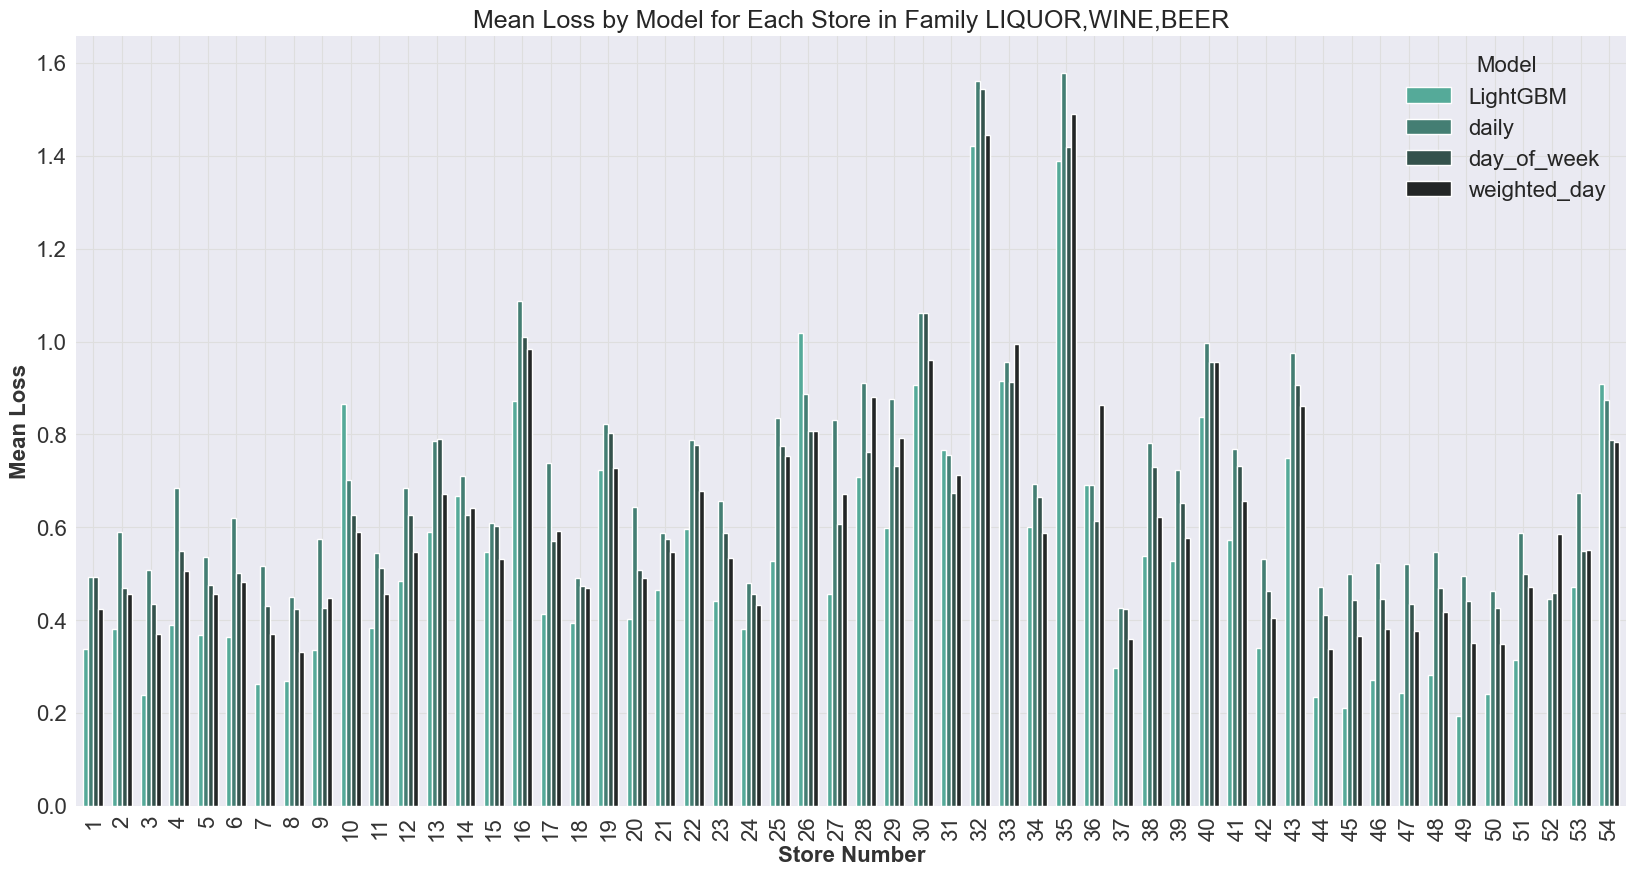

<Figure size 640x480 with 0 Axes>

In [223]:
baseline.make_family_loss_plot(family="LIQUOR,WINE,BEER")

In [34]:
# total_lgb_loss = pd.concat([eval_family_losses, baseline_loss_df]).sort_index(
#     level=["family", "store_nbr"]
# )

In [35]:
# eval_family_losses.groupby("family").mean().mean(axis=1)

family
DAIRY               0.143358
EGGS                0.286616
LIQUOR,WINE,BEER    0.506197
dtype: float64

In [102]:
# grouped_loss = total_lgb_loss.groupby("family").mean()
# lgb_series_loss = grouped_loss.mean(axis=1).rename("lgb_series_loss")
# 
# predictor_grouped_loss = predictor_eval_loss_df.groupby("family").mean()
# baseline_series_loss = predictor_grouped_loss.mean(axis=1).rename("baseline_loss")
# 
# loss_df = pd.concat([lgb_series_loss, baseline_series_loss], axis=1)

In [104]:
# total_prediction_eval_loss = loss_df["lgb_series_loss"].fillna(loss_df["baseline_loss"])
# print("Loss with LightGBM:", total_prediction_eval_loss.mean())

Loss with LightGBM: 0.4117484440634766


In [105]:
# print("Loss without LightGBM:", loss_df["baseline_loss"].mean())

Loss without LightGBM: 0.4177338467167706


## Submission
### Predict && Save

In [204]:
forecast_df = test_df.copy()

forecast_df["sales"] = None
forecast_df.rename(columns={"date": "ds"}, inplace=True)
forecast_df.set_index(["ds", "family", "store_nbr"], inplace=True)

In [230]:
prediction_df = make_submission_predictions(
    family_datasets, best_lgb_models, forecast_df
)

100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


In [231]:
baseline.add_lightgbm_prediction(prediction_df.reset_index(), "LightGBM")

In [232]:
optimal_pred = baseline.get_optimal_prediction().reset_index()
optimal_pred[optimal_pred["model"] == "LightGBM"]

,model,family,store_nbr,index,id,ds,onpromotion,sales
19008,LightGBM,"LIQUOR,WINE,BEER",1,22,3000910,2017-08-16,9,87.755197
19009,LightGBM,"LIQUOR,WINE,BEER",1,1804,3002692,2017-08-17,5,103.394984
19010,LightGBM,"LIQUOR,WINE,BEER",1,3586,3004474,2017-08-18,6,122.295577
19011,LightGBM,"LIQUOR,WINE,BEER",1,5368,3006256,2017-08-19,7,133.585152
19012,LightGBM,"LIQUOR,WINE,BEER",1,7150,3008038,2017-08-20,4,77.621734
...,...,...,...,...,...,...,...,...
19851,LightGBM,"LIQUOR,WINE,BEER",53,21208,3022096,2017-08-27,4,84.576307
19852,LightGBM,"LIQUOR,WINE,BEER",53,22990,3023878,2017-08-28,1,64.165718
19853,LightGBM,"LIQUOR,WINE,BEER",53,24772,3025660,2017-08-29,1,77.096907
19854,LightGBM,"LIQUOR,WINE,BEER",53,26554,3027442,2017-08-30,3,91.909582


In [233]:
prediction_df = baseline.get_optimal_prediction()

submission_df = save_submission(prediction_df, "test_AdvancedPredictor_with_LightGBM_fix.csv")

Submission saved to /home/tikhon/PycharmProjects/StoreSales/data/submissions/test_AdvancedPredictor_with_LightGBM_fix.csv


In [43]:
submission_df.head()

,sales
id,
3000888,4.812500
3000889,0.000000
3000890,3.310345
3000891,2041.178571
3000892,0.114286


### Plot Forecast

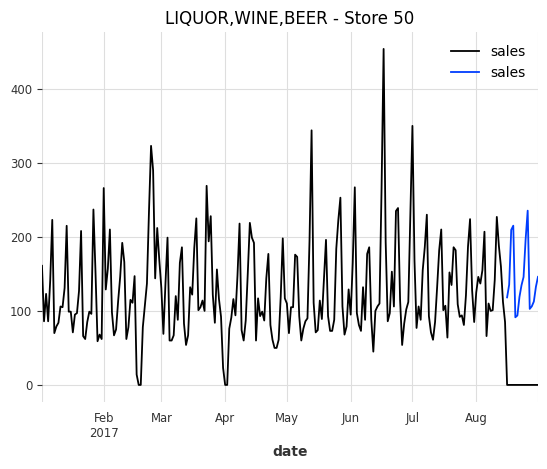

In [55]:
make_submission_forecast_plot(
    family="LIQUOR,WINE,BEER",
    i_series=49,
    dataset=family_datasets,
    forecast=prediction_df.reset_index(),
    drop_before_date=pd.Timestamp("2017-01-01"),
)

In [56]:
pprint(best_lgb_models)

{'DAIRY': LightGBMModel(lags=24, lags_past_covariates={'short_sales__sum_values': [-16, -21, -366, -373, -380], 'short_sales__median': [-16, -21, -366, -373, -380], 'short_sales__mean': [-16, -21, -366, -373, -380], 'short_sales__standard_deviation': [-16, -21, -366, -373, -380], 'short_sales__variance': [-16, -21, -366, -373, -380], 'short_sales__root_mean_square': [-16, -21, -366, -373, -380], 'short_sales__maximum': [-16, -21, -366, -373, -380], 'short_sales__minimum': [-16, -21, -366, -373, -380], 'long_sales__sum_values': [-16, -363, -377], 'long_sales__median': [-16, -363, -377], 'long_sales__mean': [-16, -363, -377], 'long_sales__standard_deviation': [-16, -363, -377], 'long_sales__variance': [-16, -363, -377], 'long_sales__root_mean_square': [-16, -363, -377], 'long_sales__maximum': [-16, -363, -377], 'long_sales__minimum': [-16, -363, -377]}, lags_future_covariates={'short_onpromotion__sum_values': [0, -7, -14, -366, -373, -380], 'short_onpromotion__median': [0, -7, -14, -366,